# Write ApRES xarrays to zarrs 
This notebook 

- loads the individual zarrs createdfrom each .dat file (using to_individual_zarr.ipynb), 
- computes the stacked profiles and adds them to the dataset
- rechunks to a reasonable chunk size in the time dimension, and
- write the whole thing to a zarr store in the ldeo-glaciology bucket.

Import packages

In [1]:
import dask
import dask.distributed 
import numpy as np
from dask.distributed import performance_report
import xarray as xr
import fsspec
import json

with open('../../../secrets/ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:46601")
client

<Client: 'tcp://127.0.0.1:46601' processes=4 threads=16, memory=58.87 GiB>

In [3]:
site = "A101"
ds = xr.open_mfdataset(f'gs://ldeo-glaciology/apres/greenland/2022/{site}/individual_zarrs_prechunked_3/dat_*',
                               chunks = {}, 
                               engine = 'zarr', 
                               consolidated = False, 
                               parallel = True)

In [4]:
ds['attenuator'] = ds.attenuator[500]
ds['AFGain'] = ds.AFGain[500]

In [5]:
for var in ds:
    print(var)
    del ds[var].encoding['chunks']

battery_voltage
chirp
latitude
longitude
profile
temperature_1
temperature_2


In [8]:
profile_stacked = ds.profile.mean(dim='chirp_num')
ds_stacked = ds.assign({'profile_stacked':profile_stacked})
ds_stacked_rechunked = ds_stacked.chunk({'time':20})
filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs/{site}_stacked_rechunked' 
mapper = fsspec.get_mapper(filename, mode='w', token=token) 
with performance_report(f'ds_stacked_rechunked_{site}.html'):
    ds_stacked_rechunked.to_zarr(mapper, consolidated=True, safe_chunks=False)

In [43]:
def zarrs_to_onezarr(site):
#site = 'A103'
    ds = xr.open_mfdataset(f'gs://ldeo-glaciology/apres/greenland/2022/{site}/individual_zarrs_prechunked_3/dat_*',
                               chunks = {}, 
                               engine = 'zarr', 
                               consolidated = False, 
                               parallel = True)
    ds['attenuator'] = ds.attenuator[500]
    ds['AFGain'] = ds.AFGain[500]


    
    for var in ds:
        print(var)
        del ds[var].encoding['chunks']

    profile_stacked = ds.profile.mean(dim='chirp_num')
    ds_stacked = ds.assign({'profile_stacked':profile_stacked})
    ds_stacked_rechunked = ds_stacked.chunk({'time':20})
    
    encoding = {i: {"dtype": "float64"} for i in ds_stacked_rechunked_small.data_vars}

    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs/{site}_stacked_rechunked_4' 
    mapper = fsspec.get_mapper(filename, mode='w', token=token) 
    with performance_report(f'ds_stacked_rechunked_{site}.html'):
        ds_stacked_rechunked.to_zarr(mapper, consolidated=True, safe_chunks=False, encoding=encoding)

In [38]:



ds_stacked_rechunked_bigger = ds_stacked_rechunked.isel(time=slice(0,1000))

encoding = {i: {"dtype": "float64"} for i in ds_stacked_rechunked_small.data_vars}

filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs/{site}_stacked_rechunked_bigger_encoding' 
mapper = fsspec.get_mapper(filename, mode='w', token=token) 
with performance_report(f'ds_stacked_rechunked_{site}.html'):
    ds_stacked_rechunked_bigger.to_zarr(mapper, consolidated=True, safe_chunks=False, encoding=encoding)

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/dataset.py:2077: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  return to_zarr(  # type: ignore


In [3]:
ds = xr.open_dataset('gs://ldeo-glaciology/apres/greenland/2022/single_zarrs/A101_stacked_rechunked',
    engine='zarr', 
    consolidated=True, 
    chunks={}) 
ds

<xarray.Dataset>
Dimensions:          (attenuator_setting_pair: 2, time: 11723,
                      chirp_time: 40001, chirp_num: 20, profile_range: 6658)
Coordinates:
    AFGain           (attenuator_setting_pair) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    attenuator       (attenuator_setting_pair) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    burst_number     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * chirp_time       (chirp_time) timedelta64[ns] 00:00:00 ... 00:00:01
    filename         (time) <U83 dask.array<chunksize=(1,), meta=np.ndarray>
  * profile_range    (profile_range) float64 0.0 0.2103 ... 1.4e+03 1.4e+03
  * time             (time) datetime64[ns] 2022-05-22T19:40:20 ... 2022-09-25...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 dask.array<chunksize=(20, 40001, 20, 2), meta=np.ndarray>
    latitude         (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    longitude        (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 dask.array<chunksize=(20, 6658, 20, 2), meta=np.ndarray>
    profile_stacked  (time, profile_range, attenuator_setting_pair) complex128 dask.array<chunksize=(20, 6658, 2), meta=np.ndarray>
    temperature_1    (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    temperature_2    (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>

In [7]:
ds_103 = xr.open_dataset('gs://ldeo-glaciology/apres/greenland/2022/single_zarrs/A103_stacked_rechunked_4',
    engine='zarr', 
    consolidated=True, 
    chunks={}) 
ds_104 = xr.open_dataset('gs://ldeo-glaciology/apres/greenland/2022/single_zarrs/A104_stacked_rechunked_4',
    engine='zarr', 
    consolidated=True, 
    chunks={}) 

In [8]:
ds_103

<xarray.Dataset>
Dimensions:          (attenuator_setting_pair: 2, time: 11763,
                      chirp_time: 40001, chirp_num: 20, profile_range: 6658)
Coordinates:
    AFGain           (attenuator_setting_pair) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    attenuator       (attenuator_setting_pair) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    burst_number     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * chirp_time       (chirp_time) timedelta64[ns] 00:00:00 ... 00:00:01
    filename         (time) <U83 dask.array<chunksize=(1,), meta=np.ndarray>
  * profile_range    (profile_range) float64 0.0 0.2103 ... 1.4e+03 1.4e+03
  * time             (time) datetime64[ns] 2022-02-17T16:37:49 ... 2022-09-25...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 dask.array<chunksize=(20, 40001, 20, 2), meta=np.ndarray>
    latitude         (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    longitude        (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) float64 dask.array<chunksize=(20, 6658, 20, 2), meta=np.ndarray>
    profile_stacked  (time, profile_range, attenuator_setting_pair) float64 dask.array<chunksize=(20, 6658, 2), meta=np.ndarray>
    temperature_1    (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    temperature_2    (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>

In [9]:
ds_104

<xarray.Dataset>
Dimensions:          (attenuator_setting_pair: 2, time: 11741,
                      chirp_time: 40001, chirp_num: 20, profile_range: 6658)
Coordinates:
    AFGain           (attenuator_setting_pair) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    attenuator       (attenuator_setting_pair) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    burst_number     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * chirp_time       (chirp_time) timedelta64[ns] 00:00:00 ... 00:00:01
    filename         (time) <U83 dask.array<chunksize=(1,), meta=np.ndarray>
  * profile_range    (profile_range) float64 0.0 0.2103 ... 1.4e+03 1.4e+03
  * time             (time) datetime64[ns] 2022-05-19T23:19:34 ... 2022-09-25...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 dask.array<chunksize=(20, 40001, 20, 2), meta=np.ndarray>
    latitude         (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    longitude        (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) float64 dask.array<chunksize=(20, 6658, 20, 2), meta=np.ndarray>
    profile_stacked  (time, profile_range, attenuator_setting_pair) float64 dask.array<chunksize=(20, 6658, 2), meta=np.ndarray>
    temperature_1    (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    temperature_2    (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>

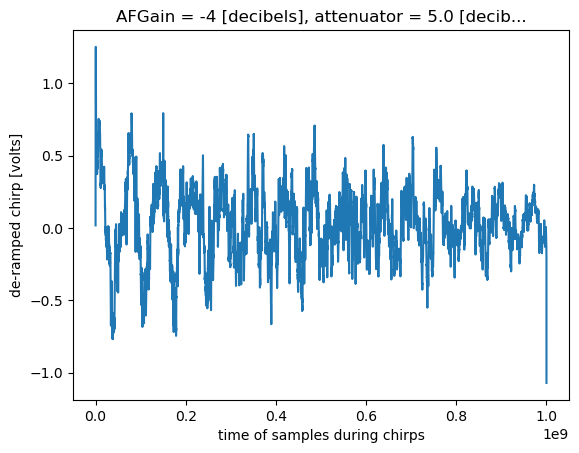

In [21]:
ds_103.chirp.isel(time=[-1],attenuator_setting_pair=[0],chirp_num=[0]).plot();

In [ ]:
zarrs_to_onezarr("A101")

In [ ]:
zarrs_to_onezarr("A103")

In [44]:
zarrs_to_onezarr("A104")

battery_voltage
chirp
latitude
longitude
profile
temperature_1
temperature_2


/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/dataset.py:2077: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  return to_zarr(  # type: ignore


In [ ]:
zarrs_to_onezarr("A104")

battery_voltage
chirp
latitude
longitude
profile
temperature_1
temperature_2


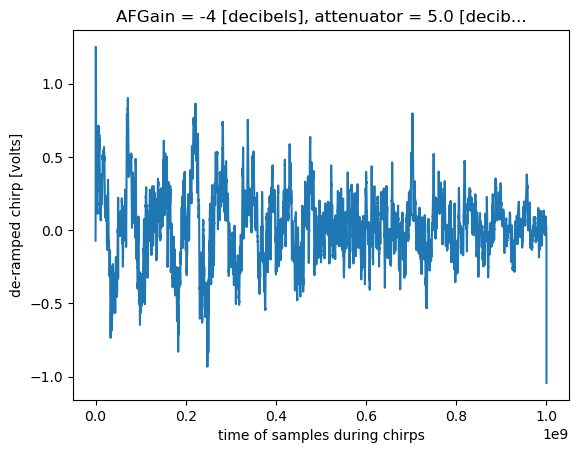

In [36]:
ds_reloaded.chirp.isel(time=[-1],attenuator_setting_pair=0,chirp_num=0).plot()